# Model Evaluation
This notebook is made to evaluate models, without having to have the specific, model defined. 

The current version is made to work well with the segmentation exercise.

This uses TorchScript, which is a compiled version of our model. 

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output


# Dataloaders
from retinal_loaders import DRIVEDataLoader



In [2]:
size = 128
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
data_path = '/dtu/datasets1/02516/phc_data'
#data_path = './phc_data'
class PhC(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        self.image_paths = sorted(glob.glob(data_path + '/images/*.jpg'))
        self.label_paths = sorted(glob.glob(data_path + '/labels/*.png'))
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        Y = self.transform(label)
        X = self.transform(image)
        return X, Y

batch_size = 6
testset = DRIVEDataLoader(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


## Load Model

In [3]:
def model_info(model):
    for name, param in model.named_parameters():
        print(f"Layer: {name}")
        print(f"Size: {param.size()}")
        print(f"Number of parameters: {param.numel()}")
        print('-' * 40)

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We can load our compiled model using
model = torch.jit.load('model.pt')
model.eval()
model_info(model)

Layer: layer0.0.weight
Size: torch.Size([128, 3, 3, 3])
Number of parameters: 3456
----------------------------------------
Layer: layer0.0.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.1.weight
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.1.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.3.weight
Size: torch.Size([128, 128, 3, 3])
Number of parameters: 147456
----------------------------------------
Layer: layer0.3.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.4.weight
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.4.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: pool0.weight
Size: torch.Size([256, 128, 3, 3])
Number of paramet

## Evaluation

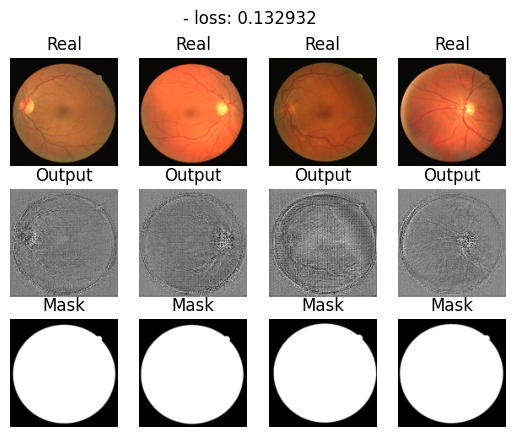

In [4]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

def focal_loss(y_real, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss for binary classification.
    """
    # Apply sigmoid to logits to get probabilities
    
    
    # Flatten the tensors
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)

    # Compute the binary cross-entropy (BCE) loss
    loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")

    # Compute the focal loss factor (1 - pt)^gamma
    pt = torch.where(y_real == 1, y_pred, 1 - y_pred)  # p_t = y_pred for positive class, 1-y_pred for negative class
    focal_weight = (1 - pt) ** gamma

    # Apply alpha weighting for the minority class
    alpha_weight = torch.where(y_real == 1, alpha, 1 - alpha)

    # Final focal loss
    loss = focal_weight * alpha_weight * loss

    return loss.mean()
# def focal_loss(y_real, y_pred,gamma = 2.):
#     y_pred_sig = torch.sigmoid(y_pred)
#     term = (1-y_pred_sig)**gamma * y_real * torch.log(y_pred_sig) + (1-y_real) * torch.log(1-y_pred_sig)
#     return (-term.sum())
def evaluate_model(model, loss_fn, test_loader):
    avg_loss = 0
    model.eval()        
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # forward
        Y_pred = model(X_batch)
        loss = loss_fn(Y_batch, Y_pred)  # forward-pass

        # calculate metrics to show the user
        avg_loss += loss.item() / len(test_loader)
    X_test, Y_test = next(iter(test_loader))

    # show intermediate results
    Y_hat = torch.sigmoid(model(X_test.to(device))).detach().cpu()
    clear_output(wait=True)
    count = 4
    for k in range(count):
        plt.subplot(3, 4, k+1)
        plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 4, k+count*1+1)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
        plt.subplot(3, 4, k+count*2+1)
        plt.imshow(Y_test[k, 0].detach().cpu(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
    plt.suptitle('- loss: %f' % ( avg_loss))
    plt.show()
    
evaluate_model(model, focal_loss, test_loader=test_loader)